# Задание 1

## Задача

У нас есть датасет клиентов банка со многими анонимными признаками и колонка "TARGET", которая обозначает доволен клиент, или нет. 1 - недоволен, 0 - доволен.
Задача состоит в построении модели, которая сможет предсказывать недовольство клиентов.<br>
Ниже оригинальное описание:

You are provided with an anonymized dataset containing a large number of numeric variables. The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers.

The task is to predict the probability that each customer in the test set is an unsatisfied customer.

File descriptions<br>
train.csv - the training set including the target<br>
test.csv - the test set without the target<br>
sample_submission.csv - a sample submission file in the correct format

Ссылка на соревнование:<br>
https://www.kaggle.com/c/santander-customer-satisfaction/overview

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
train = pd.read_csv('D:/Santander_customer_dataset/train.csv')
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
train.shape

(76020, 371)

In [5]:
#Оценим считанные данные
train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


Всего признаков очень много, причем все они анонимные, таким образом в расшировке его значения можно полагаться лишь
на его значение и название, а так же обсуждения участников соревнования.<br>
Некоторые из них уже удалось расшифровать:<br>
https://www.kaggle.com/cast42/exploring-features#num_var4-:-number-of-bank-products<br>
Признаки, начинающиеся на 'ind' обозначают какие-либо индексы, меняясь между 0 и 1. Сказать, что эти индексы означают
точно не могу.
Из переводу гугла я нашел, что 'saldo medio' - 'average amount', 'corto' - 'short time', 'largo' - 'long time'.
К тому же "Сальдо" - тоже известный термин, означающий разницу между поступлениями и расходами на счет. Таким образом
можно предположить, что эти переменные относятся к изменению баланса счетов клиентов за определенные промежутки времени.
Но почему их так много и каких именно счетов это изменения пока не понятно

В целом понять, пропущенное это значение, или валидное довольно сложно, так как неизвестен физический смысл переменной, а значит и область ее значений.
Но в признаке var3 выбросы отмечены явно (-999999). Возможно, пропущенных значений больше нет, иначе они были бы отмечены подобным образом.


## Var3

 var3 предполагается как национальность клиентов банка, поэтому -999999 является fill значением, которое нужно обработать

In [6]:
train['var3'].value_counts()[:15]


 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
 6            82
 0            75
 10           72
 11           66
 5            63
Name: var3, dtype: int64

Подавляющее кол-во клиентов имеет национальность 2

In [7]:
train = train.replace(-999999,2)

Замена самым популярным обусловлена тем, что этот признак категориальный (национальность)

In [8]:
train[train.var3==-999999].shape

(0, 371)

## Var4

num_var4, судя по обсуждению, предполагается как количество приобретенных продуктов у банка
но вполне может быть и не так. В любом случае, рассмотрим этот признак подробнее

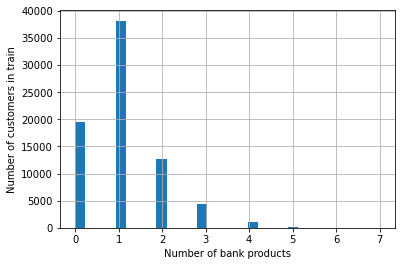

In [9]:

train.num_var4.hist(bins=30)
plt.xlabel('Number of bank products')
plt.ylabel('Number of customers in train')
plt.show()

Большинство клиентов имеют лишь один продукт. Странно, что это переменная так же обладает нулевым значением.
Возможно, я не совсем правильно понял интерпретацию.

Text(0, 0.5, 'Number of unsatisfied customers in train')

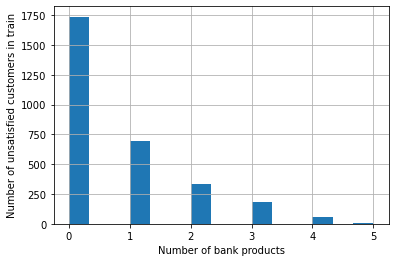

In [10]:
train[train.TARGET==1].num_var4.hist(bins=15)
plt.xlabel('Number of bank products')
plt.ylabel('Number of unsatisfied customers in train')

Но среди недовольных клиентов большинство не имеют продуктов банка. (???)

## Var15

var15 - возраст клиента(предположительно)

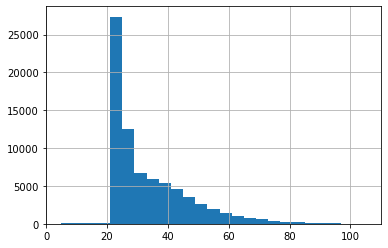

In [11]:

train['var15'].hist(bins=25)

Больш-во клиентов молодые (а учитывая, что специалисты людей до 45 считают молодыми - подавляющее боль-во)

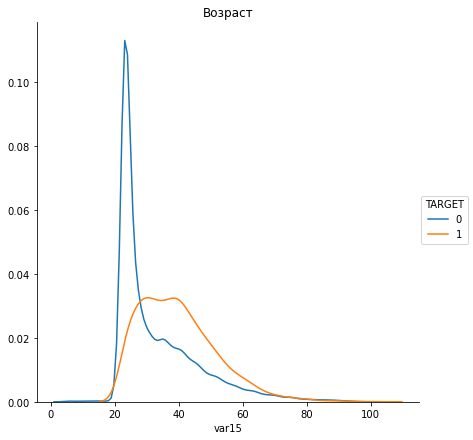

In [12]:
sns.FacetGrid(train, hue="TARGET", size=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend()
plt.title('Возраст');

Недовольные клиенты в основном старше довольных.

Пока что это все расшифрованные признаки с точной интерпретацией, что я нашел. Наверняка их больше.

## Дизбаланс классов

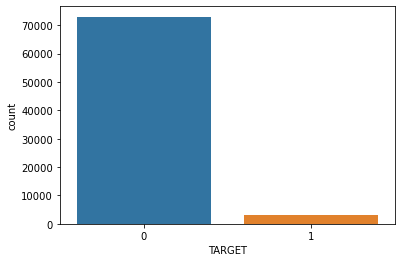

In [13]:
sns.countplot(train['TARGET'])

In [14]:
df = pd.DataFrame(train.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train.shape[0]
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


## Корреляция

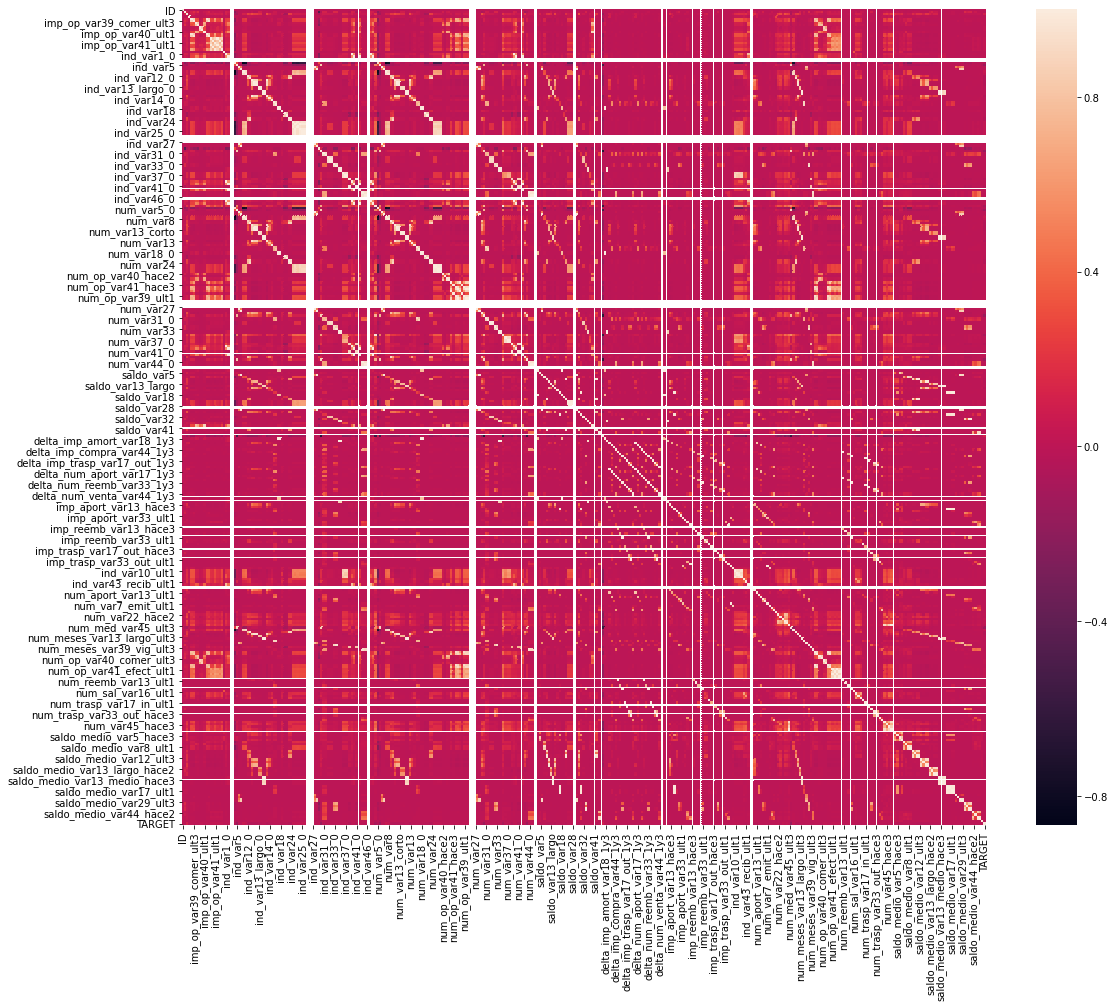

In [15]:
cor_mat = train.corr()
f, ax = plt.subplots(figsize=(18, 15))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat, ax=ax);

In [16]:
threshold = 0.7 #Высокая по шкале Чеддока
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])

unique_important_corrs = unique_important_corrs.loc[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]

unique_important_corrs

,attribute pair,correlation
3,"(ind_var6, num_var6)",1.000000
19,"(ind_var29, num_var6)",1.000000
219,"(ind_var6, num_var29)",1.000000
567,"(ind_var29, num_var29)",1.000000
609,"(delta_num_trasp_var33_out_1y3, num_trasp_var3...",1.000000
...,...,...
576,"(num_var22_hace3, num_var22_ult3)",0.702191
342,"(imp_trasp_var33_in_hace3, saldo_medio_var33_h...",0.701893
43,"(num_op_var41_efect_ult3, num_op_var41_ult3)",0.700853
607,"(num_op_var39_efect_ult3, num_op_var41_ult3)",0.700409


Кол-во коррелирующих признаков очень большое. Но если присмотреться к названиям, то можно заметить одну и ту же цифру в названиях. Тогда это имеет смысл, так как эти признаки исходят из одних данных.

Возьмем только признаки-индексы и посмотрим на их друг с другом корреляцию

In [17]:
# 
index_train = pd.DataFrame()
for column in train.columns:
    #print(column)
    if 'ind' in column:
        index_train[column] = train[column]

In [18]:
index_train.head()

,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,...,ind_var46_0,ind_var46,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,1,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


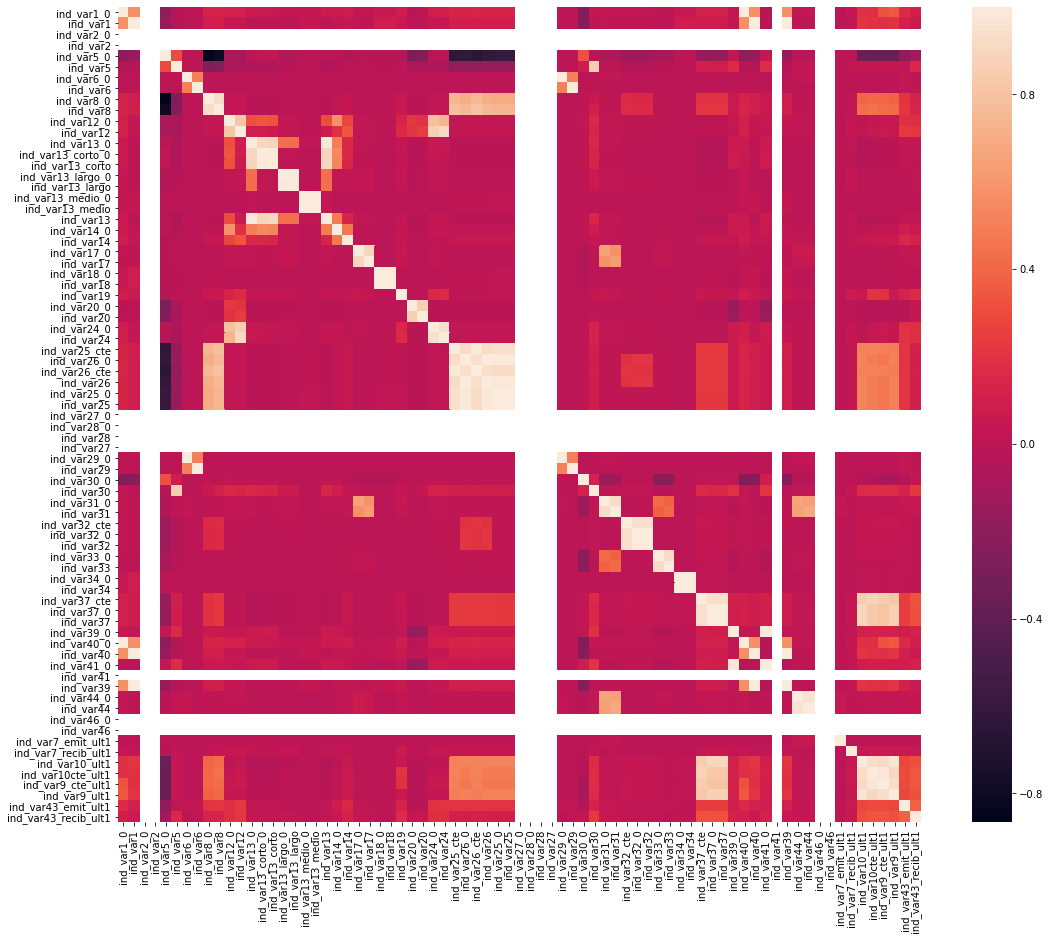

In [19]:
cor_mat = index_train.corr()
f, ax = plt.subplots(figsize=(18, 15))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat, ax=ax);

Таблица показывает, что боль-во признаков не коррелируют между собой, но при этом некоторые имеют очень сильную линейную связь.

In [20]:

threshold = 0.7 #Высокая по шкале Чеддока
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])

unique_important_corrs = unique_important_corrs.loc[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]

unique_important_corrs

,attribute pair,correlation
55,"(ind_var1_0, ind_var40_0)",0.998256
70,"(ind_var1, ind_var40)",0.994722
49,"(ind_var1, ind_var39)",0.994722
12,"(ind_var13_largo, ind_var13_largo_0)",0.991470
50,"(ind_var39_0, ind_var41_0)",0.989559
...,...,...
1,"(ind_var25, ind_var8)",0.738017
0,"(ind_var25_0, ind_var8)",0.738017
6,"(ind_var12_0, ind_var24)",0.737423
13,"(ind_var26, ind_var8_0)",0.707374


Проблема в том, что хоть их и сравнительно немного, как можно заметить на таблице, кол-во связей с сильной корреляцией все равно большое из-за кол-ва признаков. Из-за их анонимности нет четкого и хорошего способа объединить их в один признак, поэтому я воспользуюсь алгоритмами feature selection для определения наиболее полезных признаков

Одна из идей может быть создать признак, считающий количество нулей в строке. (Судя по обсуждению, этот признак может помочь.)

In [21]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)


remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)

In [22]:
train.shape

(76020, 308)

In [23]:
#Добавляем поле, в котором будет содержаться количество нулей в строке

# X = train.iloc[:,:-1]
# Y = train.TARGET
X = train.drop(["TARGET","ID"],axis=1)
Y = train.TARGET.values
X['n0'] = (X==0).sum(axis=1)
train['n0'] = X['n0']

## Feature selection

Выберем 200 наиболее полезных признаков исходя из критерия Хи-квадрат.

In [24]:
from sklearn.feature_selection import SelectKBest, chi2 # Хи-квадрат критерий
from sklearn.preprocessing import Binarizer, scale #Бинаризация, стандартизация
from sklearn.preprocessing import normalize

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectKBest(chi2, k=200 ).fit(X_bin, Y)



D:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [25]:
chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]

In [26]:
#chi2_selected_features

In [27]:
X_selected = X[chi2_selected_features]

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, stratify=Y, test_size=0.33, random_state=42)

In [29]:
X_train.shape

(50933, 200)

In [30]:
X_test.shape

(25087, 200)

In [31]:
Y_train.shape

(50933,)

In [32]:
Y_test.shape

(25087,)

## KNN

In [111]:
for neighbours in [3,7,9,15]:
    for weight in ['uniform','distance']:
        for p in [1,2]:
            print('\nMODEL: neighbours={} weight={} p={}'.format(neighbours,weight,p))
            neigh = KNeighborsClassifier(n_neighbors=neighbours, weights=weight, p=p, n_jobs=-1)
            neigh.fit(X_train,Y_train)
            Y_pred = neigh.predict(X_test)
            Y_pred_proba = neigh.predict_proba(X_test)[:,1]
            print('\nAUC on test:', roc_auc_score(Y_test, Y_pred_proba))
            print('Accuracy on test:', accuracy_score(Y_test, Y_pred))
            print(confusion_matrix(Y_test, Y_pred))
            print(np.sum(Y_pred_proba) / len(Y_pred_proba))


MODEL: neighbours=3 weight=uniform p=1

AUC on test: 0.5730848068963864
Accuracy on test: 0.9539602184398294
[[23901   193]
 [  962    31]]
0.036154183441623154

MODEL: neighbours=3 weight=uniform p=2

AUC on test: 0.5674950644383683
Accuracy on test: 0.95324271535058
[[23892   202]
 [  971    22]]
0.03711085422728903

MODEL: neighbours=3 weight=distance p=1

AUC on test: 0.5722523005104797
Accuracy on test: 0.9506915932554709
[[23810   284]
 [  953    40]]
0.03546037284094629

MODEL: neighbours=3 weight=distance p=2

AUC on test: 0.5671301584738058
Accuracy on test: 0.9498146450352772
[[23797   297]
 [  962    31]]
0.036324376356728666

MODEL: neighbours=7 weight=uniform p=1

AUC on test: 0.6178067799407004
Accuracy on test: 0.9592219077609917
[[24057    37]
 [  986     7]]
0.03606876640718869

MODEL: neighbours=7 weight=uniform p=2

AUC on test: 0.6074245877028633
Accuracy on test: 0.9598198270020329
[[24071    23]
 [  985     8]]
0.03747530024087604

MODEL: neighbours=7 weight=dist

Чем больше соседей выставляем в параметр классификатора, тем менее он чувствителен к наличию экземпляров 1-го класса (недовольный клиент). Он просто понял, что выгоднее всех считать довольными для увеличения метрики. Это одна из основных проблем сильного классового дизбаланса.

В целом могу сказать, что датасет довольно сложный, ибо в нем присутствует много ненужных и зависимых друг от друга признаков, не добавляющие ничего в модель, к тому же виден сильный классовый дизбаланс, из-за чего модель быстро скатывается в предсказание лишь одного класса для увеличения метрик. Считаю, что от алгоритма поиска ближайших соседей надо отказываться и переходить к более сложным и комплексным методам. Пример: XGBoost, CatBoost.

# Задание 2

## XGBoost

In [39]:
import xgboost as xgb

In [96]:
ratio = float(np.sum(Y == 1)) / np.sum(Y==0)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 8,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=10000)
                
clf.fit(X_train, Y_train, early_stopping_rounds=40, eval_metric="auc",
        eval_set=[(X_train, Y_train), (X_test, Y_test)])

[0]	validation_0-auc:0.5	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.5	validation_1-auc:0.5
[10]	validation_0-auc:0.5	validation_1-auc:0.5
[11]	validation_0-auc:0.5	validation_1-auc:0.5
[12]	validation_0-auc:0.5	validation_1-auc:0.5
[13]	validation_0-auc:0.5	validation_1-auc:0.5
[14]	validation_0-auc:0.5	validation_1-auc:0.5
[15]	validation_0-auc:0.5	validation_1-auc:0.5
[16]	validation_0-auc:0.5	validation_1-auc:0.5
[17]	validation_0-auc:0.5	validation_1-auc:0.5
[18]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=9999999999, n_estimators=1000,
              n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.03, reg_lambda=1,
              scale_pos_weight=0.04119870706185284, seed=10000, silent=None,
              subsample=1.0, verbosity=1)

In [113]:
Y_pred = clf.predict(X_test)
Y_pred_proba = clf.predict_proba(X_test)[:,1]
print('Final test AUC:', roc_auc_score(Y_test, Y_pred_proba))
print('Accuracy on test:', accuracy_score(Y_test, Y_pred))
print(confusion_matrix(Y_test, Y_pred))

Final test AUC: 0.8410473296473673
Accuracy on test: 0.9604177462430741
[[24094     0]
 [  993     0]]


Вот применил я XGBoost алгоритм и казалось бы - улучшение!!!
А вот нет. Если я правильно интерпретирую confusion matrix, то XGBoost просто научился выдавать ВСЕМ семплам низкую вероятность недовольства.
Т.е. мы получили такой же случай, что и с KNN, просто вероятности намного ближе находятся к нулю, оттого они не такие шумные, из-за чего и метрика AUC выше. Но по факту видно, что результат такой же - якобы все довольны.

In [114]:
np.sum(Y_pred_proba > 0.1)

0

Т.е. вероятностей недовольства больше, чем 0.1 модель не выдает в принципе.

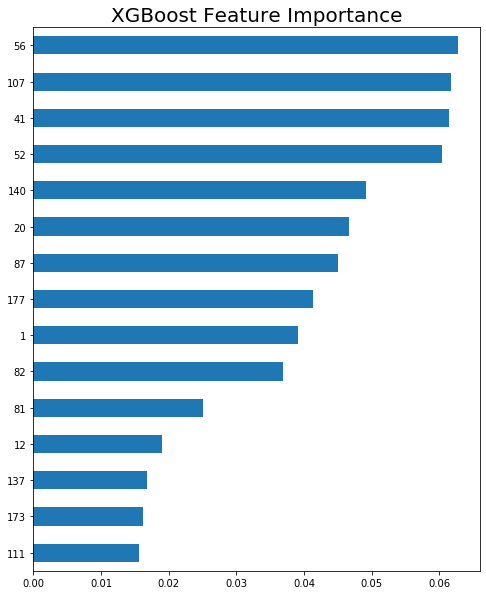

In [64]:
ts = pd.Series(clf.feature_importances_)
#ts.index = ts.reset_index()['index']
ts.sort_values()[-15:].plot(kind="barh", title=("features importance"),figsize=(8,10))

#featp = ts.sort_values()[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance', fontsize=20);

## Adding PCA components as features

In [32]:
# Add PCA components as features
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X = train.drop(["TARGET","ID"],axis=1)
X['n0'] = (X==0).sum(axis=1)
X_normalized = normalize(X, axis=0)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)
X['PCA1'] = X_pca[:,0]
X['PCA2'] = X_pca[:,1]

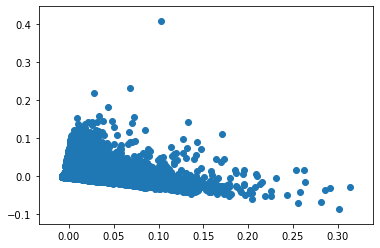

In [33]:
plt.scatter(X['PCA1'],X['PCA2'])

In [130]:
auc_metric = []
for i in range(30):
    X = train.drop(["TARGET","ID"],axis=1)
    X['n0'] = (X==0).sum(axis=1)
    X_normalized = normalize(X, axis=0)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_normalized)
    for j in range(i):
        X['PCA_'+str(j)] = X_pca[:,j]
    X_bin = Binarizer().fit_transform(scale(X))
    selectChi2 = SelectKBest(chi2, k=200 ).fit(X_bin, Y)
    chi2_selected = selectChi2.get_support()
    chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
    X_selected = X[chi2_selected_features]
    X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, stratify=Y, test_size=0.33, random_state=42)
    ratio = float(np.sum(Y == 1)) / np.sum(Y==0)
    clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 8,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=10000)
    clf.fit(X_train, Y_train, verbose=False, early_stopping_rounds=40, eval_metric="auc",
        eval_set=[(X_train, Y_train), (X_test, Y_test)])
    auc_metric.append(roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1]))
    print('auc metric added')

D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


D:\Anaconda\envs\facebook_RCNN\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


auc metric added


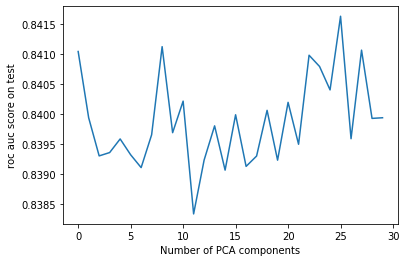

In [133]:
plt.xlabel('Number of PCA components')
plt.ylabel('roc auc score on test')
plt.plot(auc_metric)

судя по графику можно заметить, что кол-во компонент 25 дает наилучшие результаты, повышая auc метрику на 0.0005, поэтому можно сказать, что PCA помог улучшить точность. Однако он не решил основную проблему - понижение вероятности недовольства всех клиентов к нулю. Настолько маленькое улучшение не стоит того, а учитывая, что некоторое кол-во компонент ухудшило результат, к тому же не наблюдается четкой закономерности между улучшением результата и кол-вом компонент, можно сказать, что эти признаки ничего значимого в модель не добавили.

В итоге я получил, что PCA признаки не оказывают существенного или даже ожидаемого воздействия на точность модели.
Хоть они и добавляют датасету вариацию, на данный момент цель модели при обучении заключается
в уменьшении вероятности недовольства клиентов, чему добавление признаков PCA может лишь помешать, что мы и видим
на графике выше.
Хочу сказать, что хоть мои результаты и приближены к наилучшим результатам участников соревнования, я еще не заметил
среди них обсуждения или поднятия вопроса насчет того, что модель просто не детектит недовольство у клиентов вообще.
И ни в одной из публично выложенных тетрадок они не выводят и не анализируют матрицу ошибок, показывая лишь ту метрику, которую
просят организаторы.

К тому же, просмотрев их submission, прикрепленный к публичным тетрадкам я заметил те же очень низкие вероятности, что
наводит меня на мысль, что для достижения лучших показателей люди приняли решение схитрить и не пытаться детектить
меньший класс, а попытаться наоборот - сделать ему как можно меньшую вероятность.
Это даст меньшую ошибку на правильных предсказаниях, но большую на неправильных. Из-за большого классового дизбаланса
auc метрика в итоге повысится.

Идеи для решения проблемы:

1.Создать собственную метрику с увеличенным штрафом за предсказание недовольного клиента как довольного

2.Использование нейронных сетей(???)

# Задача 3 : обучение полносвязной нейронной сети

In [35]:
from sklearn.neural_network import MLPClassifier

In [43]:
alphas = np.linspace(0, 10, 10)
train_err = []
test_err = []
overall_best_model = 0
overall_best_auc_score = 0
for i in range(1,25):
    best_auc_score = 0
    best_model = 0
    best_alpha = 0
    for alpha in alphas:
        mlp_model = MLPClassifier(hidden_layer_sizes = (i,), alpha=alpha,
                                  solver = 'lbfgs', 
                                  activation = 'logistic', random_state = 42,verbose=True)
        mlp_model.fit(X_train, Y_train)
        if roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1]) > best_auc_score:
            best_auc_score = roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1])
            best_model = mlp_model
            best_alpha = alpha
        if roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1]) > overall_best_auc_score:
            overall_best_auc_score = roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1])
            overall_best_model = mlp_model
    
    print('Train ROC AUC score with {} hidden layers and {} alpha: {}'.format(i, best_alpha, roc_auc_score(Y_train, mlp_model.predict_proba(X_train)[:,1])))
    print('Test ROC AUC score with {} hidden layers and {} aplha: {}'.format(i, best_alpha, best_auc_score))
    train_err.append(roc_auc_score(Y_train, mlp_model.predict_proba(X_train)[:,1]))
    test_err.append(best_auc_score)

Train ROC AUC score with 1 hidden layers and 8.88888888888889 alpha: 0.5001561533520875
Test ROC AUC score with 1 hidden layers and 8.88888888888889 aplha: 0.7241142049296516
Train ROC AUC score with 2 hidden layers and 2.2222222222222223 alpha: 0.5148911578062929
Test ROC AUC score with 2 hidden layers and 2.2222222222222223 aplha: 0.6080693015798897
Train ROC AUC score with 3 hidden layers and 8.88888888888889 alpha: 0.5480883743565597
Test ROC AUC score with 3 hidden layers and 8.88888888888889 aplha: 0.7220920603768172
Train ROC AUC score with 4 hidden layers and 10.0 alpha: 0.6987936159331608
Test ROC AUC score with 4 hidden layers and 10.0 aplha: 0.6947327440502209
Train ROC AUC score with 5 hidden layers and 3.3333333333333335 alpha: 0.7234930699341188
Test ROC AUC score with 5 hidden layers and 3.3333333333333335 aplha: 0.7540240177131011
Train ROC AUC score with 6 hidden layers and 3.3333333333333335 alpha: 0.6652182509911508
Test ROC AUC score with 6 hidden layers and 3.33333

Я делаю перебор параметров по alpha и количеству скрытых слоев.
Для каждого кол-ва слоев подбирается наилушчий альфа из отрезка 1-10 на основании ROC AUC по тестовой выборке.

Также для детектирования недообучения или переобучения я вывожу ошибку на тренировочный выборке для анализа результатов.
В целом, ошибка на тесте почти всегда меньше ошибки при тренировке. Это обсуловлено, скорее всего, удачным сплитом на тест и трейн.

Недообучение проявляется случайно, что довольно странно, но вполне может объяснится сильным классовым дизбалансом.
При более высоком кол-ве слоев точность возрастает, но переобучение по-прежнему не наблюдается.


Text(0,0.5,'Test ROC AUC score')

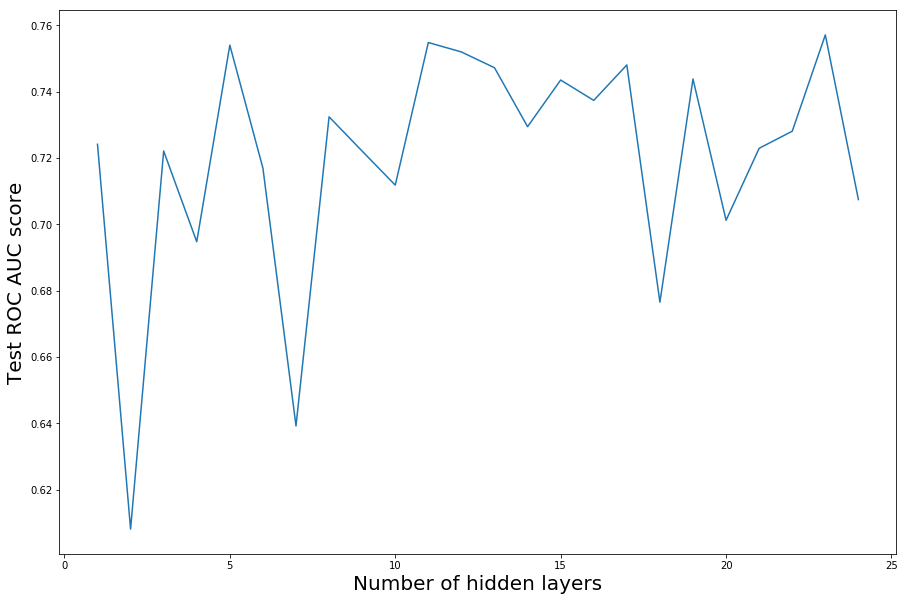

In [65]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(1,24,24),test_err)
plt.xlabel('Number of hidden layers',fontsize=20)
plt.ylabel('Test ROC AUC score',fontsize=20)

Этот график показывает зависимость ошибки на тестовой выборке от количества скрытых слоев.
Наилучший результат показал классификатор с 23 слоями: 0.7571

In [45]:
roc_auc_score(Y_test, overall_best_model.predict_proba(X_test)[:,1])

0.7571043498563155

In [48]:
print(confusion_matrix(Y_test, overall_best_model.predict(X_test)))

[[24094     0]
 [  993     0]]


Ожидаемая ситуация, как и с XGBoost классификатором - все клиенты были причислены к довольным. Метрика хуже лишь потому, что средняя вероятность недовольства выше, чем у XGBoost, скорее всего, из-за намного более тщательного подбора параметров.

In [56]:
np.sum(overall_best_model.predict_proba(X_test)[:,1] > 0.2)

0

Клиентов с вероятность недовольства больше 20% классификатор не выдает в принципе. 

MLP классификатор показал достойные с точки зрения метрики AUC результаты, но тем не менее
ушел в ту же 'яму', что и другие классификаторы, занижая вероятность недовольства.

# Задача 4 : обучение полносвязной нейронной сети с использованием PCA

In [35]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X = train.drop(["TARGET","ID"],axis=1)
X['n0'] = (X==0).sum(axis=1)
X_normalized = normalize(X, axis=0)
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_normalized)
for j in range(25):
    X['PCA_'+str(j)] = X_pca[:,j]

Использую PCA На 25 компонент, так как это количество показало наилучший результат во второй лабе

In [37]:
X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectKBest(chi2, k=200 ).fit(X_bin, Y)
chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
X_selected = X[chi2_selected_features]
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, stratify=Y, test_size=0.33, random_state=42)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [38]:
from sklearn.neural_network import MLPClassifier

In [39]:
alphas = np.linspace(0, 10, 10)
train_err = []
test_err = []
overall_best_model = 0
overall_best_auc_score = 0
for i in range(1,25):
    best_auc_score = 0
    best_model = 0
    best_alpha = 0
    for alpha in alphas:
        mlp_model = MLPClassifier(hidden_layer_sizes = (i,), alpha=alpha,
                                  solver = 'lbfgs', 
                                  activation = 'logistic', random_state = 42,verbose=True)
        mlp_model.fit(X_train, Y_train)
        if roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1]) > best_auc_score:
            best_auc_score = roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1])
            best_model = mlp_model
            best_alpha = alpha
        if roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1]) > overall_best_auc_score:
            overall_best_auc_score = roc_auc_score(Y_test, mlp_model.predict_proba(X_test)[:,1])
            overall_best_model = mlp_model
    
    print('Train ROC AUC score with {} hidden layers and {} alpha: {}'.format(i, best_alpha, roc_auc_score(Y_train, mlp_model.predict_proba(X_train)[:,1])))
    print('Test ROC AUC score with {} hidden layers and {} aplha: {}'.format(i, best_alpha, best_auc_score))
    train_err.append(roc_auc_score(Y_train, mlp_model.predict_proba(X_train)[:,1]))
    test_err.append(best_auc_score)

Train ROC AUC score with 1 hidden layers and 10.0 alpha: 0.5158473231701768
Test ROC AUC score with 1 hidden layers and 10.0 aplha: 0.5184494750378071
Train ROC AUC score with 2 hidden layers and 8.88888888888889 alpha: 0.6991706534366469
Test ROC AUC score with 2 hidden layers and 8.88888888888889 aplha: 0.7298695876531254
Train ROC AUC score with 3 hidden layers and 7.777777777777779 alpha: 0.47170720800099264
Test ROC AUC score with 3 hidden layers and 7.777777777777779 aplha: 0.7099687018058091
Train ROC AUC score with 4 hidden layers and 7.777777777777779 alpha: 0.5316911361363631
Test ROC AUC score with 4 hidden layers and 7.777777777777779 aplha: 0.713592829728411
Train ROC AUC score with 5 hidden layers and 10.0 alpha: 0.5705443007526547
Test ROC AUC score with 5 hidden layers and 10.0 aplha: 0.5773219041132203
Train ROC AUC score with 6 hidden layers and 7.777777777777779 alpha: 0.5404185380568505
Test ROC AUC score with 6 hidden layers and 7.777777777777779 aplha: 0.601807572

Технология перебора такая же, как и в прошлой лабе

Text(0, 0.5, 'Test ROC AUC score')

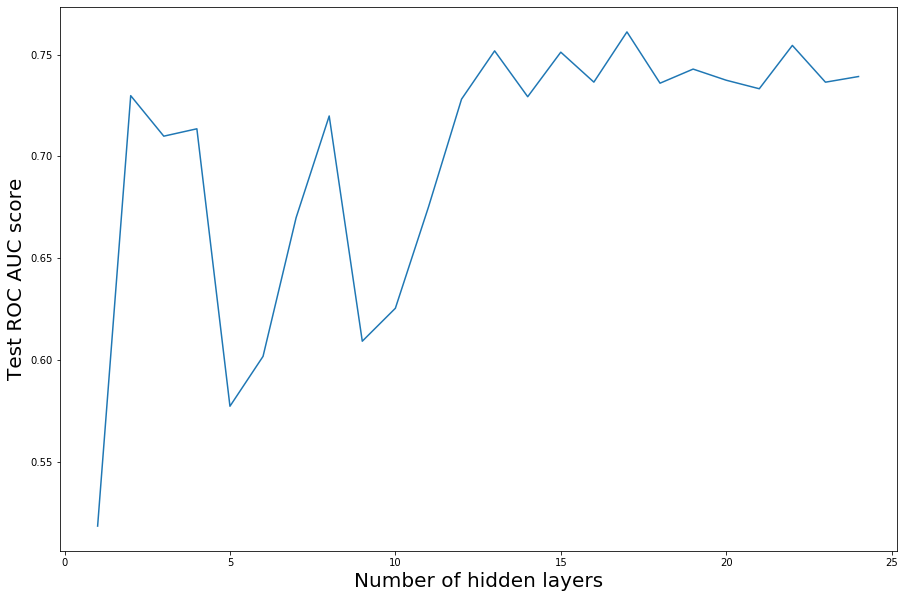

In [40]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(1,24,24),test_err)
plt.xlabel('Number of hidden layers',fontsize=20)
plt.ylabel('Test ROC AUC score',fontsize=20)

При использовании фичей PCA график получился менее шумный. Наилучший результат показал классификатор с 17 слоями: 0.7611

In [41]:
roc_auc_score(Y_test, overall_best_model.predict_proba(X_test)[:,1])

0.7611797356961502

In [42]:
print(confusion_matrix(Y_test, overall_best_model.predict(X_test)))

[[24094     0]
 [  993     0]]


Та же проблема, какой классификатор не бери и какие преобразования не делай, модели все равно скатываются в предсказание всех клиентов как довольных.

In [46]:
np.sum(overall_best_model.predict_proba(X_test)[:,1] > 0.16)

0

Больше 16% недовольства нет ни у одного из клиентов тестовой выборки.
В целом могу сказать, что PCA, предположительно, уменьшил шум признаков. Улучшение метрики на 1% не считаю важным, так как эта метрика не раскрывает истинное поведение алгоритма.
Но все же, численно, с PCA результаты получились лучше.

## Задание 5: Обучение random forests и gradient boosted trees.

In [44]:
from sklearn.ensemble import RandomForestClassifier

test_auc_scores = []
train_auc_scores = []
oob_scores = []
for i in range(20):
    Forest = RandomForestClassifier(n_estimators=50 + 50*i,max_depth=12,oob_score=True,random_state=42,verbose=True,n_jobs=2)
    Forest.fit(X_train, Y_train)
    test_auc_scores.append(roc_auc_score(Y_test, Forest.predict_proba(X_test)[:,1]))
    train_auc_scores.append(roc_auc_score(Y_train, Forest.predict_proba(X_train)[:,1]))
    oob_scores.append(Forest.oob_score_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_job

Text(0, 0.5, 'Train ROC AUC score')

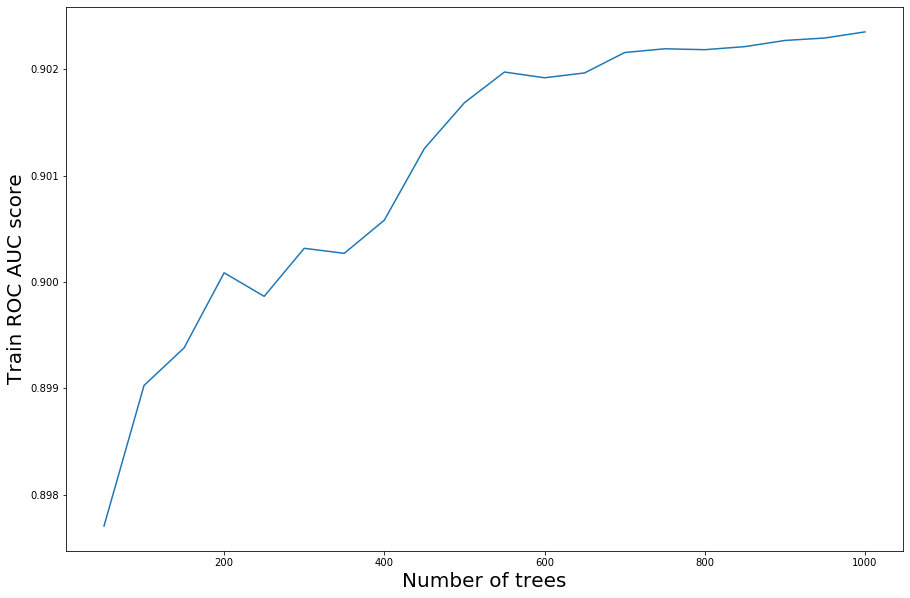

In [47]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(50,1000,20),train_auc_scores)
plt.xlabel('Number of trees',fontsize=20)
plt.ylabel('Train ROC AUC score',fontsize=20)

Text(0, 0.5, 'Test ROC AUC score')

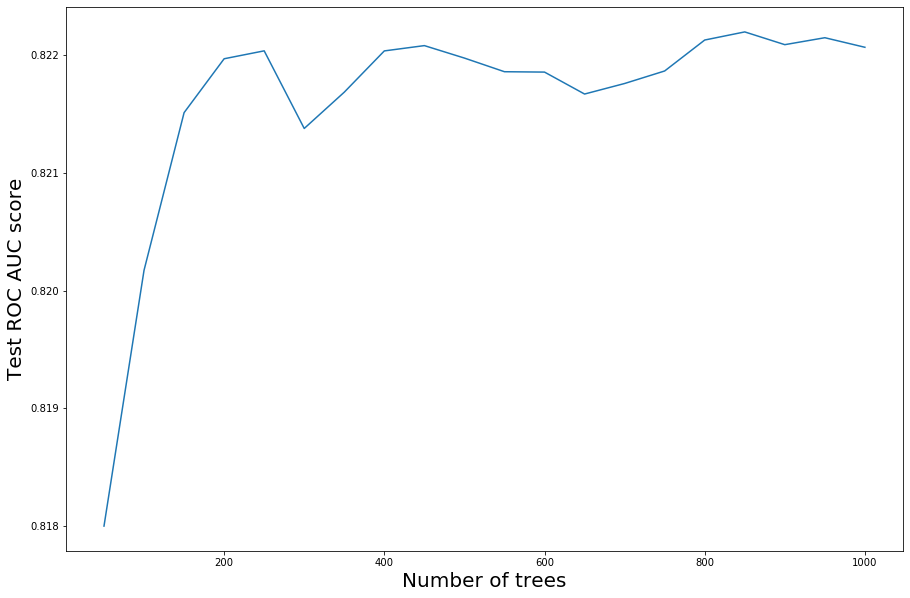

In [48]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(50,1000,20),test_auc_scores)
plt.xlabel('Number of trees',fontsize=20)
plt.ylabel('Test ROC AUC score',fontsize=20)

Text(0, 0.5, 'oob error score')

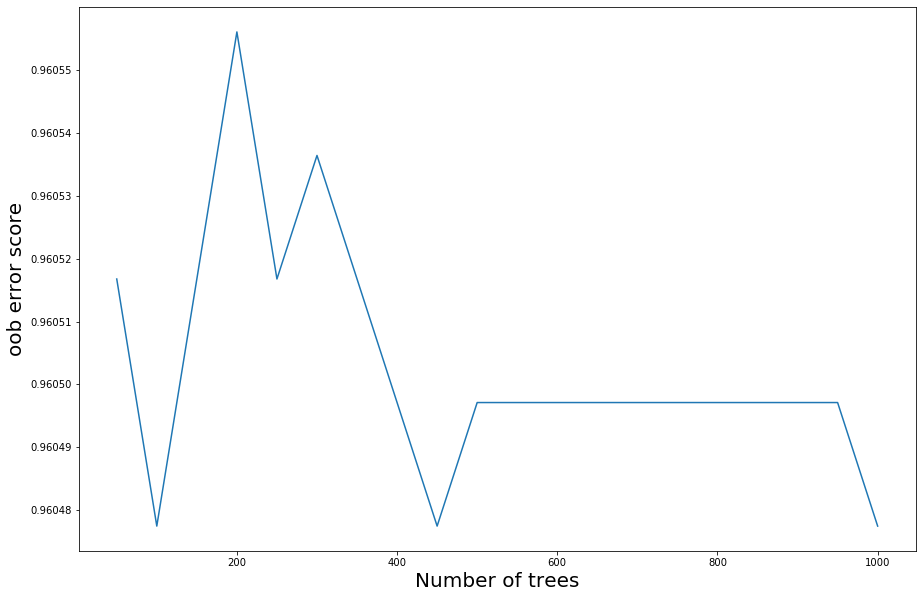

In [49]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(50,1000,20),oob_scores)
plt.xlabel('Number of trees',fontsize=20)
plt.ylabel('oob error score',fontsize=20)

Переобучение не наблюдается. Ошибка на тесте, показанная методом Random Forests является лучшей, не беря в расчет XGBoost алгоритм, гиперпараметры для которого я взял с обсуждения соревнования. Считаю, что многие методы, построенные на деревьях, могли бы достичь результата XGBoost при тюнинге параметров, что доказывает результат Random Forest, при том что параметры я не тюнил, а лишь взял похожие на XGBoost.

In [40]:
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

grad_test_auc_scores = []
grad_train_auc_scores = []
for i in range(20):
    GradBoost = HistGradientBoostingClassifier(learning_rate=0.1, max_iter=50 + 50*i,max_depth=12,verbose=1)
    GradBoost.fit(X_train, Y_train)
    grad_test_auc_scores.append(roc_auc_score(Y_test, GradBoost.predict_proba(X_test)[:,1]))
    grad_train_auc_scores.append(roc_auc_score(Y_train, GradBoost.predict_proba(X_train)[:,1]))

Binning 0.081 GB of data: 0.290 s
Fitting gradient boosted rounds:
[1/50] 1 tree, 31 leaves, max depth = 12, in 0.070s
[2/50] 1 tree, 31 leaves, max depth = 9, in 0.072s
[3/50] 1 tree, 31 leaves, max depth = 11, in 0.073s
[4/50] 1 tree, 31 leaves, max depth = 9, in 0.114s
[5/50] 1 tree, 31 leaves, max depth = 11, in 0.062s
[6/50] 1 tree, 31 leaves, max depth = 9, in 0.071s
[7/50] 1 tree, 31 leaves, max depth = 10, in 0.068s
[8/50] 1 tree, 31 leaves, max depth = 10, in 0.070s
[9/50] 1 tree, 31 leaves, max depth = 8, in 0.070s
[10/50] 1 tree, 31 leaves, max depth = 8, in 0.067s
[11/50] 1 tree, 31 leaves, max depth = 11, in 0.063s
[12/50] 1 tree, 31 leaves, max depth = 8, in 0.076s
[13/50] 1 tree, 31 leaves, max depth = 10, in 0.075s
[14/50] 1 tree, 31 leaves, max depth = 11, in 0.071s
[15/50] 1 tree, 31 leaves, max depth = 12, in 0.069s
[16/50] 1 tree, 31 leaves, max depth = 9, in 0.065s
[17/50] 1 tree, 31 leaves, max depth = 10, in 0.078s
[18/50] 1 tree, 31 leaves, max depth = 11, in 0.

Text(0, 0.5, 'Train ROC AUC score')

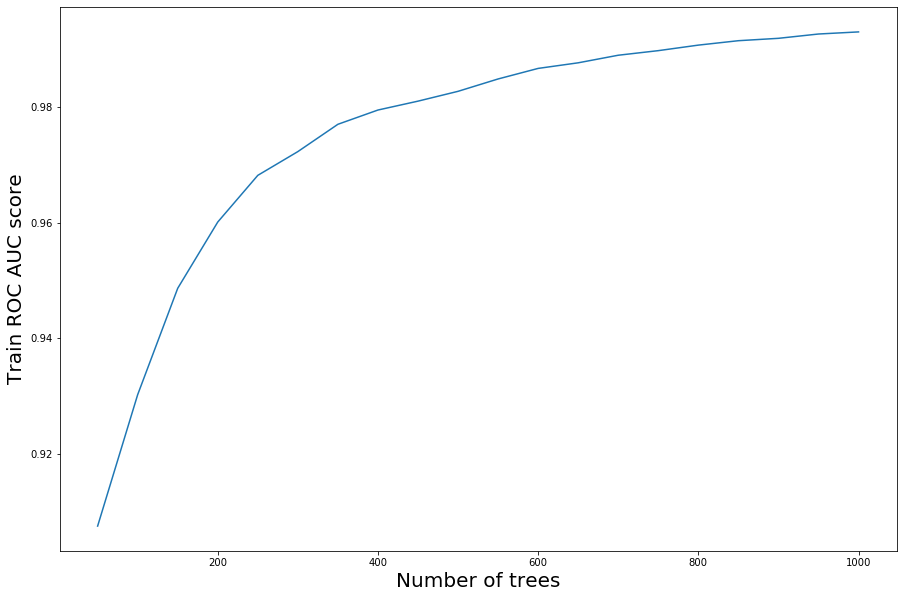

In [50]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(50,1000,20),grad_train_auc_scores)
plt.xlabel('Number of trees',fontsize=20)
plt.ylabel('Train ROC AUC score',fontsize=20)

Text(0, 0.5, 'Test ROC AUC score')

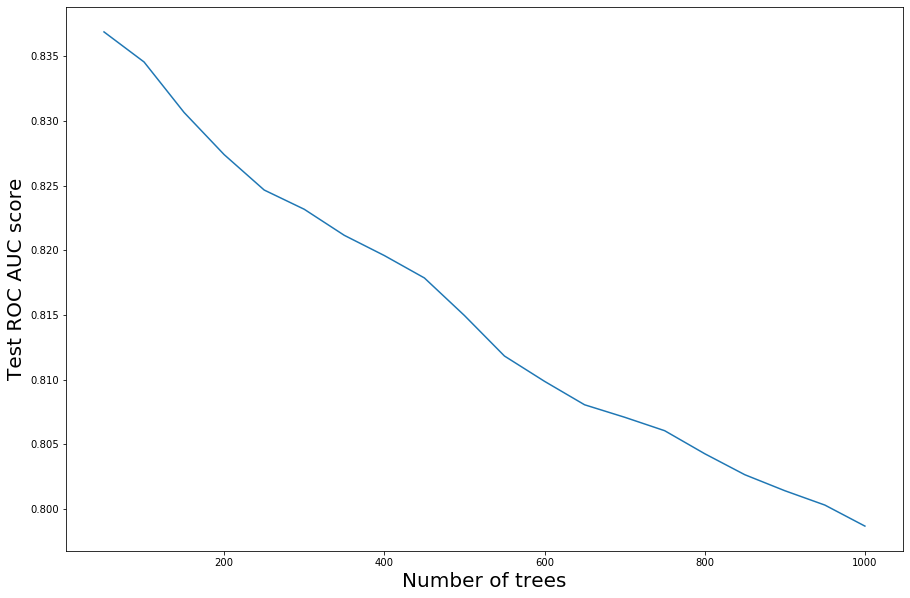

In [51]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(50,1000,20),grad_test_auc_scores)
plt.xlabel('Number of trees',fontsize=20)
plt.ylabel('Test ROC AUC score',fontsize=20)

Вместо Градиент бустинга я использую HistGradientBoosting. Его особенность в том, что он быстрее сходится на больших размерах данных (от 10000, как написано в документации).
Здесь уже наблюдается переобучение при увеличении кол-ва деревьев.

В целом наилучшими вариантами оказались методы, основанные на деревьях. XGBoost дал лучший результат благодаря сильно подстроенным под выборку параметрам. Из-за специфичности датасета не думаю, что глубокое обучение могло бы достичь лучшего результата, ведь, как я уже описывал, достижение хороших метрик в этой задаче сводится к как можно большему "игнорированию" одного из классов.

## Задание 6: Методы кластеризации

Учитывая специфику датасета мои ожидания таковы, что методы кластеризации будут сводить все данные к одному классу, и различить их будет невозможно.

### K-Means

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42,n_jobs=4).fit(X_selected)

In [51]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
accuracy_score(Y, kmeans.labels_)

0.9557221783741121

Метрика accuracy Хорошая, но она максимально бесполезна для оценивания реальной точности алгоритма в данном случае. Давайте просто проверим, сколько предположений кластера о недовольных посетителях совпало с реальностью?

In [54]:
counter = 0
for i in range(len(Y)):
    if Y[i] == 1 and kmeans.labels_[i] == 1:
        counter += 1

In [55]:
counter

6

Совпало ровно 6. Не густо...

In [56]:
len(Y[Y == 1])

3008

Хотя всего их 3008

In [57]:
len(kmeans.labels_[kmeans.labels_ == 1])

370

Предположений всего 370.

### DBSCAN

In [81]:
from sklearn.cluster import DBSCAN


DB_SCAN = DBSCAN(eps=7, min_samples=6).fit(X_selected)


In [82]:
np.unique(DB_SCAN.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64)

Всего получилось 29 классов.

In [83]:
unique, counts = np.unique(DB_SCAN.labels_, return_counts=True)

In [84]:
dict(zip(unique, counts))

{-1: 67530,
 0: 3460,
 1: 57,
 2: 2509,
 3: 238,
 4: 1076,
 5: 635,
 6: 46,
 7: 134,
 8: 61,
 9: 16,
 10: 77,
 11: 15,
 12: 27,
 13: 10,
 14: 6,
 15: 33,
 16: 7,
 17: 7,
 18: 6,
 19: 18,
 20: 7,
 21: 6,
 22: 7,
 23: 6,
 24: 6,
 25: 5,
 26: 5,
 27: 10}

Посмотрим, удалось ли алгоритму выделить недовольных клиентов в какой-то отдельный класс, или хотя бы не дать им попасть в общую кучу класса -1

In [85]:
angry_customers = {}
for i in range(len(Y)):
    if Y[i] == 1:
        if DB_SCAN.labels_[i] in angry_customers.keys():
            angry_customers[DB_SCAN.labels_[i]] += 1
        else:
            angry_customers[DB_SCAN.labels_[i]] = 0

In [86]:
angry_customers

{-1: 2574, 0: 358, 2: 50, 4: 13, 5: 6, 17: 0, 3: 0}

К сожалению, не удалось. Недовольные клиенты полностью смешались с довольными и различить их, как мне и казалось, невозможно

### Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

X_batch = X_selected[0:20000]

Spec = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=42).fit(X_batch)

D:\Anaconda\envs\work\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
Y_batch = Y[0:20000]

#### Финальный вывод:
От метода к методу, получающиеся результаты сильно похожи. Лучше всех показал себя XGBoost да и то благодаря early stopping, из-за чего модель недоучилась, что приводит к метрикам лучше.
Это связано с огромным классовым дизбалансом, из-за которого сеть приходит к тому, что нулевые метрики наиболее эффективные, что на деле приводит к 100% довольным клиентам. (И вправду эффективно)
Изначально этот датасет очень смещенный и не может привести к хорошей модели с высокой обобщающей способностью. Даже если удастся решить проблему классового дизбаланса, мы придем к серьезному переобучению на недовольных клиентах датасета, либо к переобучению на довольных клиентах. Второй вариант позволяет достигнуть лучшей метрики, поэтому он и был выбран участниками соревнования, так как оверфит на 97% данных всегда лучше оверфита на 3% данных.
Мне было интересно, выстрелит ли какой-нибудь из рассмотренных мной методов, пытаясь прийти к другому выводу, нежели зануление метрик, однако такого, к сожалению, не произошло. Ключ к хорошему результату - серьезный препроцессинг данных.
Метрики для всех подходов можно просмотреть в логах тетрадки, в том числе и матрицу ошибок.